# Preprocessing

In [2]:
import pandas as pd
import re

# Load the CSV file
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv', encoding='ISO-8859-1')

# Step 2: Drop rows where any of the relevant columns have NaN or empty values
df_cleaned = df.dropna(subset=['headline', 'sentiment'])

# Optionally, remove any rows where the headline column is empty or contains only whitespace
df_cleaned = df_cleaned[df_cleaned['headline'].str.strip().astype(bool)]

# Step 3: Create a new column 'sentiment' based on the positivity score
def categorize_sentiment(positivity):
    if positivity == -1:
        return 'negative'
    elif positivity == 0:
        return 'neutral'
    elif positivity == 1:
        return 'positive'
    else:
        return None  # In case there are out-of-range values

df_cleaned['sentiment'] = df_cleaned['sentiment'].apply(categorize_sentiment)

# Step 4: Preprocess the headline
def preprocess_headline(headline):
    # Convert text to lowercase
    headline = headline.lower()
    
    # Replace numbers with <NUMBER>
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    
    # Replace percentages with <PERCENTAGE>
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    
    # Replace other numerical representations (e.g., currency) if necessary
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)  # Replace currency amounts
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)  # Replace dates

    # Remove non-alphanumeric characters (except spaces and punctuation)
    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)

    # Optional: Remove excessive whitespace
    headline = re.sub(r'\s+', ' ', headline).strip()
    
    return headline

# Apply preprocessing to the 'headline' column only
df_cleaned['cleaned_headline'] = df_cleaned['headline'].apply(preprocess_headline)

# Step 5: Check the cleaned data (only showing headlines here)
print(df_cleaned[['headline', 'cleaned_headline']].head())


                                            headline  \
0              Yields on CDs Fell in the Latest Week   
1  Currency Trading: Dollar Remains in Tight Rang...   
2               Stocks Fall Again; BofA, Alcoa Slide   
3  U.S. Dollar Falls Against Most Currencies; Dec...   
4               Defending Yourself Against Deflation   

                                    cleaned_headline  
0              yields on cds fell in the latest week  
1  currency trading: dollar remains in tight rang...  
2               stocks fall again; bofa, alcoa slide  
3  u.s. dollar falls against most currencies; dec...  
4               defending yourself against deflation  


Distribution Check

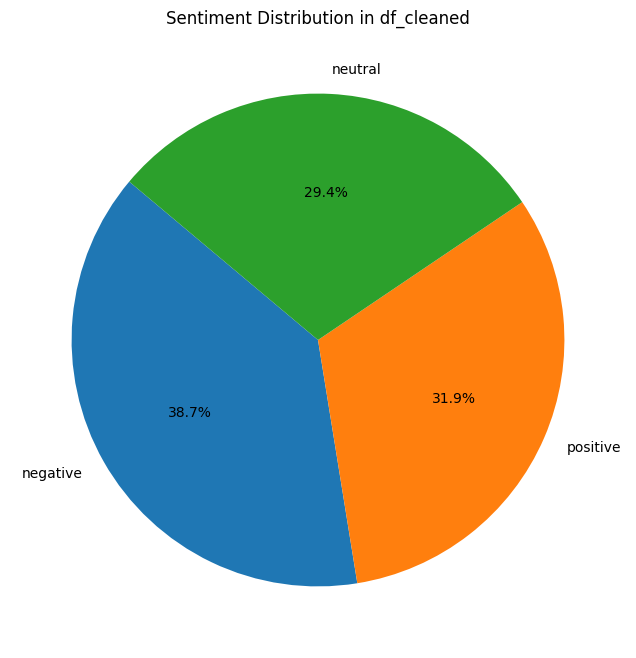

In [3]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df_cleaned['sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in df_cleaned')
plt.show()

Downsampling Neutral

sentiment
neutral     418
negative    418
positive    418
Name: count, dtype: int64


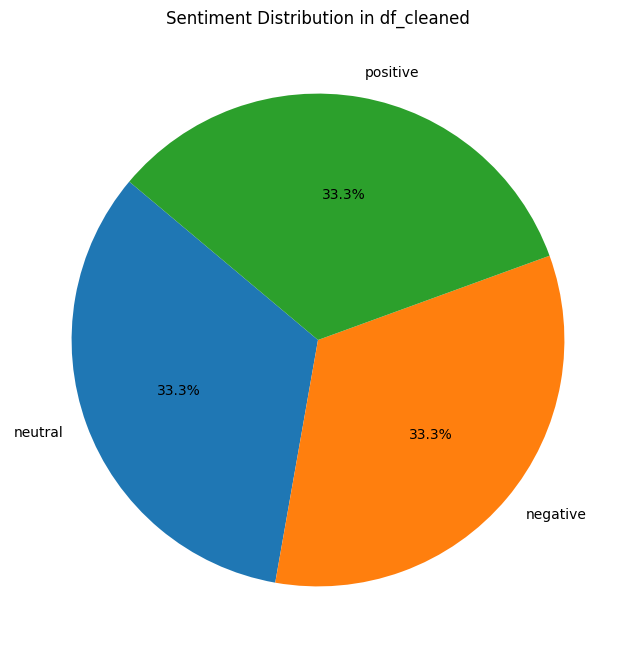

In [11]:
# Get the counts of each sentiment class
class_counts = df_cleaned['sentiment'].value_counts()

target_count = class_counts.min()
df_neutral = df_cleaned[df_cleaned['sentiment'] == 'neutral'].sample(target_count, random_state=42)
df_pos = df_cleaned[df_cleaned['sentiment'] == 'positive'].sample(target_count, random_state=42)
df_neg = df_cleaned[df_cleaned['sentiment'] == 'negative'].sample(target_count, random_state=42)

df_balanced = pd.concat([df_neg, df_pos,
                         df_neutral])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Count the occurrences of each sentiment
sentiment_counts = df_balanced['sentiment'].value_counts()
print(sentiment_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in df_cleaned')
plt.show()

# LLM Model

In [ ]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_finbert_sentiment(df, headlines = None):
    """
    Predict sentiment for headlines in a DataFrame using FinBERT
    
    Args:
    df (pandas.DataFrame): DataFrame with a 'headline' column
    
    Returns:
    pandas.DataFrame: Original DataFrame with additional sentiment columns
    """
    
    if df is None:
        # Step 2: Convert the Series to a DataFrame
        df = pd.Series(headlines, name="split_headline").to_frame()
            
        result_df = df.copy()


    # Prepare headlines
    headlines = result_df['split_headline'].tolist()

    # Tokenize the headlines
    inputs = tokenizer(headlines, return_tensors="pt", padding=True, truncation=True)
    
    # Perform prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get the predicted labels
    predicted_labels = torch.argmax(predictions, dim=1)
    
    # Map numeric labels to sentiment
    label_map = {0: 'positive', 1: 'negative', 2: 'neutral'}
    predicted_sentiments = [label_map[label.item()] for label in predicted_labels]
    
    # Add predictions to the DataFrame
    result_df['finbert_sentiment'] = predicted_sentiments
    
    # Add confidence scores
    result_df['negative_confidence'] = predictions[:, 0].numpy()
    result_df['neutral_confidence'] = predictions[:, 1].numpy()
    result_df['positive_confidence'] = predictions[:, 2].numpy()
    
    return result_df


In [20]:
import re
import pandas as pd

def split_headline(headline):
    """
    Split headline and return the first part before specified punctuation marks
    
    Args:
    headline (str): Full headline
    
    Returns:
    str: First part of the headline
    """
    # Split at common punctuation marks
    split_patterns = [
        r'\s*---\s*',  # Split at ---
        r'\s*;\s*',    # Split at ;
    ]
    
    for pattern in split_patterns:
        parts = re.split(pattern, headline)
        if len(parts) > 1:
            return parts[0].strip()
    
    # If no splitting occurs, return the original headline
    return headline.strip()

In [21]:
df_balanced['split_headline'] = df_balanced['headline'].apply(split_headline)

In [22]:
df_with_sentiments = predict_finbert_sentiment(df_balanced)
df_with_sentiments[['split_headline', 'sentiment', 'finbert_sentiment']]

,split_headline,sentiment,finbert_sentiment
0,Stock Prices End Mixed; Bonds Gain,neutral,positive
1,Abreast of the market: Stock prices finish mos...,negative,negative
2,US Jobless Claims Disappoint,negative,negative
3,There Is No 'Structural' Unemployment Problem,negative,neutral
4,Housing Starts Tumbled 2.2% In September,neutral,negative
...,...,...,...
1249,Flat Finish for Oil on Mixed Data,neutral,positive
1250,Pendulum Swings for Retirement Charges,neutral,neutral
1251,"Neither the Numbers, Nor Fed Members, Signal R...",neutral,neutral
1252,U.S. News: Fed Looks at Low-Rate Peg,neutral,neutral


Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.65      0.60       418
     neutral       0.59      0.66      0.62       418
    positive       0.69      0.52      0.59       418

    accuracy                           0.61      1254
   macro avg       0.62      0.61      0.61      1254
weighted avg       0.62      0.61      0.61      1254


Overall Metrics:
Accuracy: 0.6077
Precision: 0.6173
Recall: 0.6077
F1 Score: 0.6069


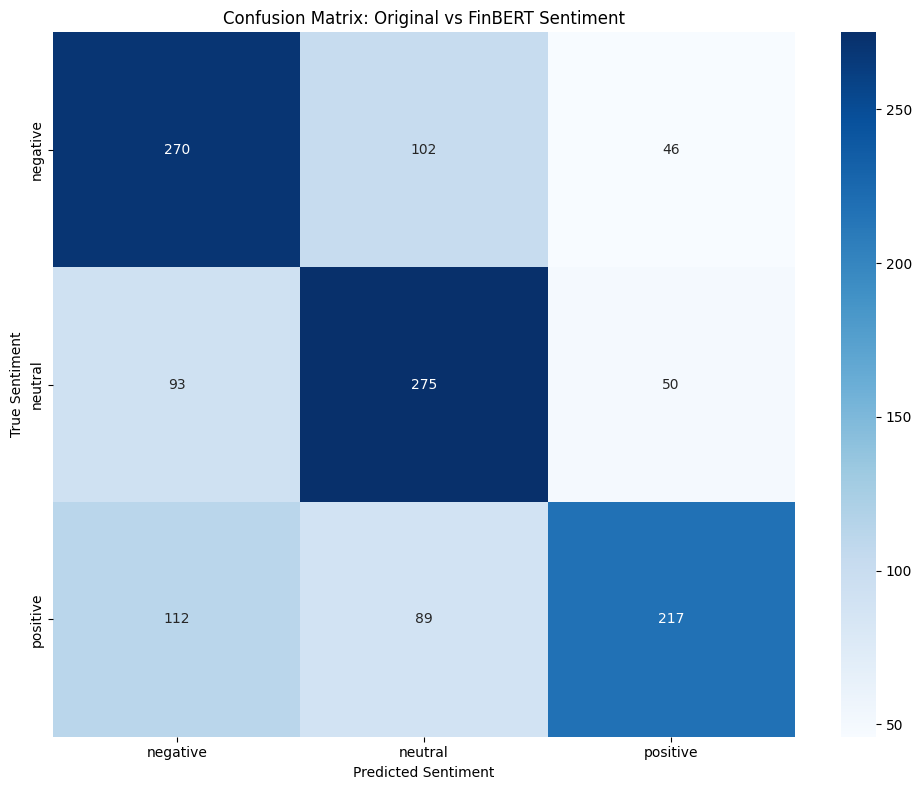


Misclassification Analysis:
Total Misclassified: 492
Misclassification Rate: 39.23%

Misclassification Breakdown:
  sentiment finbert_sentiment  count
0  negative           neutral    102
1  negative          positive     46
2   neutral          negative     93
3   neutral          positive     50
4  positive          negative    112
5  positive           neutral     89

Confidence Scores for Misclassified Samples:
negative_confidence: 0.2398
neutral_confidence: 0.4066
positive_confidence: 0.3536

Example Misclassified Headlines:

Original Headline: Stock Prices End Mixed; Bonds Gain --- Investors Are Torn By Fears About IBM, Relief Over Rates
First Part Headline: Stock Prices End Mixed; Bonds Gain
Original Sentiment: neutral
FinBERT Sentiment: positive
--------------------------------------------------

Original Headline: There Is No 'Structural' Unemployment Problem; A look at the skills-jobs mismatch finds no evidence that changes in the economy explain high joblessness. The proble

<Figure size 1200x600 with 0 Axes>

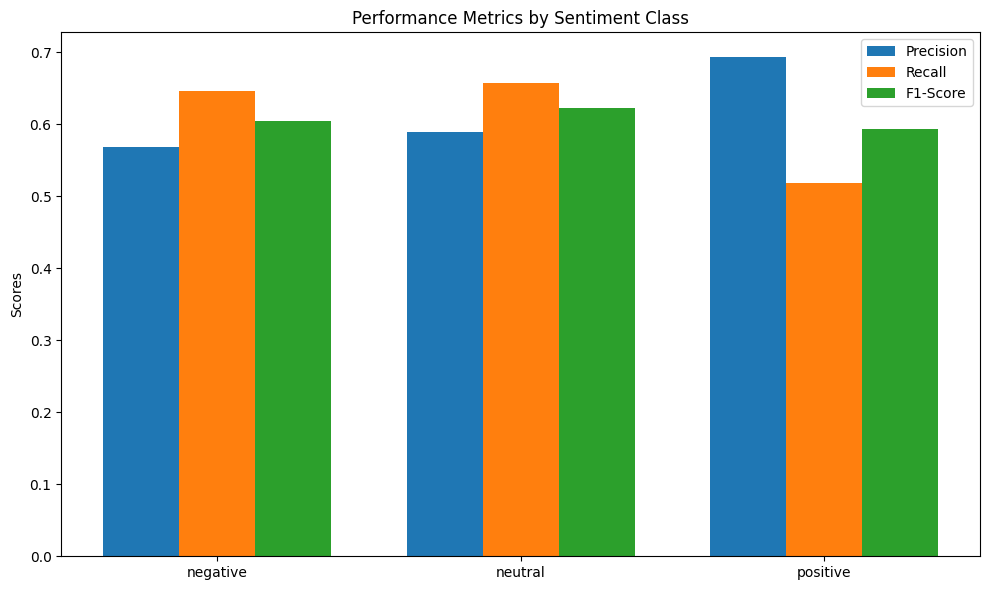

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the data
comparison_df = df_with_sentiments[['headline', 'split_headline', 'sentiment', 'finbert_sentiment']]

# Convert sentiments to a consistent format (in case they're different)
def normalize_sentiment(sentiment):
    sentiment = str(sentiment).lower()
    if sentiment in ['negative', 'neg', '-1', '0']:
        return 'negative'
    elif sentiment in ['positive', 'pos', '1', '2']:
        return 'positive'
    else:
        return 'neutral'

# Normalize sentiments
y_true = comparison_df['sentiment'].apply(normalize_sentiment)
y_pred = comparison_df['finbert_sentiment'].apply(normalize_sentiment)

# Generate detailed classification report
print("Detailed Classification Report:")
print(classification_report(y_true, y_pred))

# Compute additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix: Original vs FinBERT Sentiment')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.tight_layout()
plt.show()

# Detailed misclassification analysis
misclassified = comparison_df[y_true != y_pred]
print("\nMisclassification Analysis:")
print("Total Misclassified:", len(misclassified))
print("Misclassification Rate: {:.2f}%".format(len(misclassified) / len(comparison_df) * 100))

# Breakdown of misclassifications
misclass_breakdown = misclassified.groupby(['sentiment', 'finbert_sentiment']).size().reset_index(name='count')
print("\nMisclassification Breakdown:")
print(misclass_breakdown)

# Confidence analysis for misclassified samples
def get_confidence_for_misclassified(misclassified):
    misclassified_indices = misclassified.index
    confidence_cols = ['negative_confidence', 'neutral_confidence', 'positive_confidence']
    
    print("\nConfidence Scores for Misclassified Samples:")
    for col in confidence_cols:
        mean_confidence = df_with_sentiments.loc[misclassified_indices, col].mean()
        print(f"{col}: {mean_confidence:.4f}")

get_confidence_for_misclassified(misclassified)

# Examples of misclassified headlines
print("\nExample Misclassified Headlines:")
for _, row in misclassified.iterrows():
    print(f"\nOriginal Headline: {row['headline']}")
    print(f"First Part Headline: {row['split_headline']}")
    print(f"Original Sentiment: {row['sentiment']}")
    print(f"FinBERT Sentiment: {row['finbert_sentiment']}")
    print("-" * 50)

# Per-class performance visualization
plt.figure(figsize=(12, 6))
class_report = classification_report(y_true, y_pred, output_dict=True)
classes = ['negative', 'neutral', 'positive']
metrics = ['precision', 'recall', 'f1-score']

data = [[class_report[cls][metric] for metric in metrics] for cls in classes]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, [row[0] for row in data], width, label='Precision')
rects2 = ax.bar(x, [row[1] for row in data], width, label='Recall')
rects3 = ax.bar(x + width, [row[2] for row in data], width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Sentiment Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [27]:
# Example usage
new_headlines = ["Stock market soars to new heights", "Company XYZ files for bankruptcy", "Economy is steady"]
predicted_sentiments =  predict_finbert_sentiment(None, headlines = new_headlines)['finbert_sentiment']
print("Predictions for new headlines:")
for headline, sentiment in zip(new_headlines, predicted_sentiments):
    print(f"Headline: {headline}")
    print(f"Predicted sentiment: {sentiment}")
    print()

UnboundLocalError: local variable 'result_df' referenced before assignment